# Decision trees

The approach presented in this path, will be one that uses the classical Decision Trees to manage the classification problem. Most of the steps presented here will repeat itself from the XGBoost path, but the algorithm analysis will be a little bit different. This shows that by following the procedure proposed in this study, in general, leads to an interesting pipeline that enables the user to run several machine learning algorithms from the same rundown. Also, this algorithm will be used for each generated feature, namelly:

- Periodograms
- Bayes Similarity
- Hidden Markov Models

All approaches will pass trough the common machine learning pipeline, where we must:

- Normalize the data (if necessary)
- Divide the data between trainning and testing
- Search the hyper parameters
- Cross validate the models
- Analyse the results

## Periodograms

The application using the periodograms is actually pretty simple, now that the data is prepared and all of those preprocessing from last pipeline step is already done. The algorithm became straigh forward. First it is necessary to read the features generated.

In [1]:
import pickle 

file_name = './features/freq_data/freq_data.pkl' 
with open(file_name, 'rb') as file:
    freq_data = pickle.load(file)
freq_data.keys()

dict_keys(['features', 'labels'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [2]:
import numpy as np
from sklearn import preprocessing

# Create the label encoder
le_freq = preprocessing.LabelEncoder()
le_freq.fit(freq_data['labels'])

# Define the regression model
regressors = preprocessing.normalize(freq_data['features']['spec'])
outputs = le_freq.transform(freq_data['labels'])

In [3]:
regressors.shape[1]

12758

Also it is interesting to reduce the features dimension to build a simpler model. It is not necessary to create a classifier with such amount (12758 features...) of features. There are several techniques that can be used to reduce the features dimensions. The Principal Component Analisys, is very effective when dealing with high dimensional data. Here the `PCA` algorithm from the `sklearn` library is used.

In [4]:
from sklearn.decomposition import PCA

# Create the PCA decomposer
pca_dec = PCA(n_components=70)#, svd_solver='arpack')

# Train the PCA object
pca_dec.fit(regressors)

# Transform the data using
# the PCA model
pca_regressor = pca_dec.transform(regressors)

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    pca_regressor, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `max_depth` is the best for this model and data?
- Wich cost function is the best to be selected as `criterion` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Define the model parameters 
param_dist = {
    'random_state' : 0,
    'criterion' : 'entropy', # or 'entropy' for information gain
    'max_depth' : 0
}

# Create the range parameters to 
# search
max_features_dim = X_train.shape[1]
max_depth = [k + 1 for k in range(max_features_dim)]

# Create the plotting variable
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}

# Estimate and validate each candidate
for opt in max_depth:
    # Update the model parameters
    param_dist['max_depth'] = opt
    # Create the xgBoost classifier
    clfs = DecisionTreeClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    plot_vals['true']['confirmed targets'].append(conf_mat[0,0])
    plot_vals['true']['eclipsing binaries'].append(conf_mat[1,1])
    plot_vals['false']['confirmed targets'].append(conf_mat[0,1])
    plot_vals['false']['eclipsing binaries'].append(conf_mat[1,0])

In [7]:
from utils import *

# Line plot each confidence matrix parameter
x_data = [max_depth, max_depth, max_depth, max_depth]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion parameters plot',
                         color_index=colors,
                         y_axis={'label': 'Proportion'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

Loading BokehJS ...

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis.  

In [8]:

param_dist = {
    'random_state': 0,
    'criterion' : 'entropy', # or 'entropy' for information gain
    'max_depth' : max_depth[2]
}

# Create the model classifier
freq_clf = DecisionTreeClassifier(**param_dist)

# Train the model
freq_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Results

In this part it is presented the results from the classification algorithm. Both regarding the data visualization and the model classification quality. 

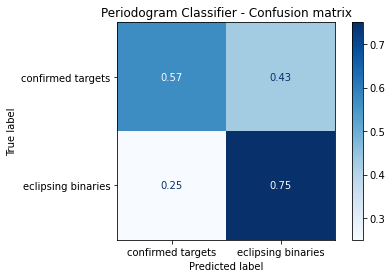

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(freq_clf, X_test, y_test,
                             display_labels=le_freq.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Periodogram Classifier - Confusion matrix')
plt.show()

#### Comments

*From this result, it possible to see that the decision tree model is able to learn some information from eclipsing binaries, as it just get 25% of the testing data wrong. But when analysing the confirmed targets results, it is possible to see that we have a coin toss algorithm, since it cannot learn anything from the exo planets data. Comparing with the XGBoost algorithm it is possible to see a big downgrade on the classification results, ensuring the outstanding capability of the boosting feature of the algorithm.*

## Naive Bayes likelihood

Here we will read the Naive Bayes model parameters estimated for each light curve and use this information as feature for the xgBoost classifier. To start this approach, we must first read the Bayes features saved from last step:

In [10]:
import pickle 

file_name = './features/bayes_data/nx_12/bayes_data.pkl'
with open(file_name, 'rb') as file:
    bayes_data = pickle.load(file)
bayes_data.keys()

dict_keys(['features', 'labels'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [11]:
import numpy as np
from sklearn import preprocessing

# Create the label encoder
le_bayes = preprocessing.LabelEncoder()
le_bayes.fit(bayes_data['labels'])

# Define the regression model
regressors = preprocessing.normalize(bayes_data['features']['params'])
outputs = le_bayes.transform(bayes_data['labels'])

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    regressors, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `criterion` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Define the model parameters 
param_dist = {
    'random_state' : 0,
    'criterion' : 'gini', # or 'entropy' for information gain
    'max_depth' : 0
}

# Create the range parameters to 
# search
max_features_dim = X_train.shape[1]
max_depth = [k + 1 for k in range(max_features_dim)]

# Create the plotting variable
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}

# Estimate and validate each candidate
for opt in max_depth:
    # Update the model parameters
    param_dist['max_depth'] = opt
    # Create the xgBoost classifier
    clfs = DecisionTreeClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    plot_vals['true']['confirmed targets'].append(conf_mat[0,0])
    plot_vals['true']['eclipsing binaries'].append(conf_mat[1,1])
    plot_vals['false']['confirmed targets'].append(conf_mat[0,1])
    plot_vals['false']['eclipsing binaries'].append(conf_mat[1,0])

In [14]:
from utils import *

# Line plot each confidence matrix parameter
x_data = [max_depth, max_depth, max_depth, max_depth]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion parameters plot',
                         color_index=colors,
                         y_axis={'label': 'Proportion'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis. The model is saved on a particular variable, such as `bayes_clf` to be further used in some vote chain model, if further necessary.

In [15]:

param_dist = {
    'random_state': 0,
    'criterion' : 'gini', # or 'entropy' for information gain
    'max_depth' : max_depth[3]
}

# Create the model classifier
bayes_clf = DecisionTreeClassifier(**param_dist)

# Train the model
bayes_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Results

In this part it is presented the results from the classification algorithm. Both regarding the data visualization and the model classification quality. 

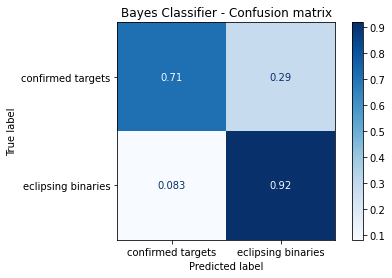

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(bayes_clf, X_test, y_test,
                             display_labels=le_bayes.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Bayes Classifier - Confusion matrix')
plt.show()

#### Comments

*This one of the most interesting results... note that this same result appered on the XGBoost classifier algorithm. This enables the speculation that the Naive Bayes parameters provide an information so clean about the classes that any algorithm, as complex as possible, or as simple as possible, will be able to find a classification pattern. To examplify this assumption we can plot the tree such as:*

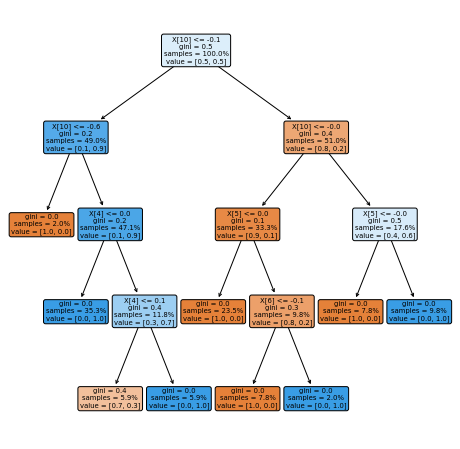

In [17]:
from sklearn import tree

plt.figure(figsize=(8,8))
p_tree = tree.plot_tree(bayes_clf, 
                        precision=1, 
                        filled=True, 
                        proportion=True, 
                        rotate=True, 
                        rounded=True)

---

## Hidden Markov Models

Here we use the model estimated from the Hidden Markov Models library, wich is the estimated $A$ matrix, or the so called transition probability matrices as feature for the learning classifier. For that we must read the pickle file with the desired features:

In [18]:
import pickle 

file_name = './features/hmm_data/nx_20/hmm_data.pkl'
with open(file_name, 'rb') as file:
    hmm_data = pickle.load(file)
hmm_data.keys()

dict_keys(['y', 't', 'labels', 'features'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [19]:
import numpy as np
from sklearn import preprocessing

# Encode the label
le_hmm = preprocessing.LabelEncoder()
le_hmm.fit( hmm_data['labels'] )

# Define the model order
feat = hmm_data['features']
nx = feat['prob_matrix'][0].shape[0]

regressors = []
for phi in feat['prob_matrix']:
    # Reshape the regressor
    reg = phi.reshape(nx*nx)
    # Add to the regressors
    regressors.append(reg)   
# Normalize the regressors
regressors = preprocessing.normalize(regressors)
# Define outputs as encoded variables
outputs = le_hmm.transform(hmm_data['labels'])

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    regressors, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `objective` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Define the model parameters 
param_dist = {
    'random_state' : 0,
    'criterion' : 'gini', # or 'entropy' for information gain
    'max_depth' : 0
}

# Create the range parameters to 
# search
max_features_dim = X_train.shape[1]
max_depth = [k + 1 for k in range(max_features_dim)]

# Create the plotting variable
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}

# Estimate and validate each candidate
for opt in max_depth:
    # Update the model parameters
    param_dist['max_depth'] = opt
    # Create the xgBoost classifier
    clfs = DecisionTreeClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    plot_vals['true']['confirmed targets'].append(conf_mat[0,0])
    plot_vals['true']['eclipsing binaries'].append(conf_mat[1,1])
    plot_vals['false']['confirmed targets'].append(conf_mat[0,1])
    plot_vals['false']['eclipsing binaries'].append(conf_mat[1,0])

In [22]:
from utils import *

# Line plot each confidence matrix parameter
x_data = [max_depth, max_depth, max_depth, max_depth]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion parameters plot',
                         color_index=colors,
                         y_axis={'label': 'Proportion'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis. The model is saved on a particular variable, such as `hmm_clf` to be further used in some vote chain model, if further necessary.

In [23]:

param_dist = {
    'random_state': 0,
    'criterion' : 'gini', # or 'entropy' for information gain
    'max_depth' : max_depth[0]
}

# Create the model classifier
hmm_clf = DecisionTreeClassifier(**param_dist)

# Train the model
hmm_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Results

Here we include some visualization results for the xgBoost algorithm classification. As the first result, we just print the model eval metrics, here the *log loss* of the model, for both the trainning and testing data.

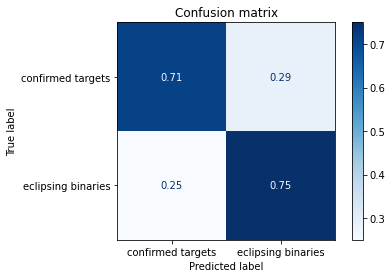

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(hmm_clf, X_test, y_test,
                             display_labels=le_hmm.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Confusion matrix')
plt.show()

#### Comments

*Note that here, the same happened with the XGBoost classifier... so the conclusion must be the same as the presented one from the Naive Bayes method. The information from the Hidden Markov Models, only contain so much information that only allows the classifier to get to this performance. This is shown by the best complexity found for this algorithm, which is $n_x=1$, therefore the simplest model as possible. To illustrate that, we can show the tree such as:*

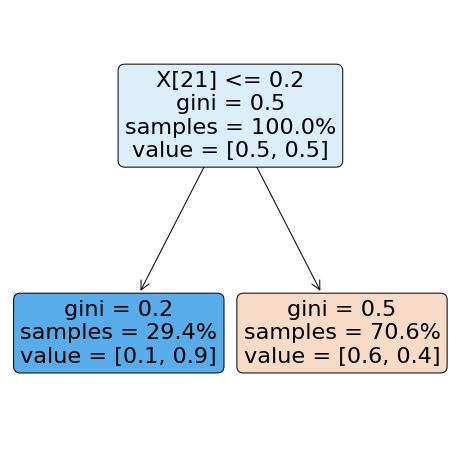

In [25]:
from sklearn import tree

plt.figure(figsize=(8,8))
p_tree = tree.plot_tree(hmm_clf, 
                        precision=1, 
                        filled=True, 
                        proportion=True, 
                        rotate=True, 
                        rounded=True)